# Data Science for Good - Jobs in LA

### Goal
The goal of this project is to uncover biases in job postings provided by the city of L.A to help optimize recruitment and decrease unconscious discriminations.

### Entry Data
The entry data is composed of a set of 683 text files representative of the job bulletins. Each files is composed of a title, the job descrription, the requirements, the selection methods, the deadline to apply an d other interestings fields.

### Action plan
We'll be performing the following actions :
1. Exploratory Data Analysis
2. Uncover gender bias
3. Explore other biases by correlation analysis


## 1. Exploratory Data Analysis

In [1]:
# Imports
import os 
import pandas as pd
import re
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import genderdecoder
import assess

In [2]:
# variable definition
path_bulletins = r".\data-science-for-good-city-of-los-angeles\CityofLA\Job Bulletins"
bulletins=os.listdir(path_bulletins)

In [3]:
def days_between(d1, d2):
# computes the duration in days between d2 and d1   
    try:
        d1 = datetime.strptime(d1.strftime("%Y-%m-%d"), "%Y-%m-%d")
        d2 = datetime.strptime(d2.strftime("%Y-%m-%d"), "%Y-%m-%d")
        return abs((d2 - d1).days)
    except:
        return np.nan


def to_dataframe(num, df, locationdir):
# Reads all the files located in locationdir and retreives all interesting field as well as coputing interesting stats.
    """"function to extract features from job bulletin text files and convert to
    pandas dataframe.
    Arguments :
    1.the number of files to be read
    2.dataframe object                                      
    3.directory in which the files are located                        
    """
    opendate=re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)')       #match open date
    
    salary=re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')       #match salary
    
    requirements=re.compile(r'(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)')      #match requirements
    
    for no in range(0,num):
        nblines = 0
        nbchars = 0
        with open(locationdir+"/" +bulletins[no],encoding="ISO-8859-1") as f:         #reading files 
                try:
                    file=f.read().replace('\t','')
                    nblines = file.count('\n')
                    raw_text=file.replace('\n',' ')
                    data=file.replace('\n','')
                    nbchars = len(data)
                    # print(data)
                    headings=[heading for heading in file.split('\n') if heading.isupper()]             ##getting heading from job bulletin

                    
                    try:
                        sal=re.search(salary,data)
                    except:
                        sal=np.nan
                        #print(bulletins[no])
                        #print("no matching salary")
                    
                    try:
                        odate=datetime.strptime(re.search(opendate,data).group(3),'%m-%d-%y')
                    except:
                        date=np.nan
                        #print(bulletins[no])
                        #print("no matching opendate")
                        
                    try:
                        req=re.search(requirements,data).group(2)
                    except Exception as e:
                        try:
                            req=re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',
                                                              data)[0][1][:1200]).group(1)
                        except:
                            date=np.nan
                            #print(bulletins[no])
                            #print("no matching requirements")
                    
                    duties=re.search(r'(DUTIES)(.*)(REQ[A-Z])',data).group(2)
                    
                        
                    try:
                        enddate=re.search(
                                r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})'
                                ,data).group()
                    except Exception as e:
                        enddate=np.nan
                        #print(bulletins[no])
                        #print("no matching enddate")
                    
                    try:
                        selection= [z[0] for z in re.findall('([A-Z][a-z]+)((\s\.\s)+)',data)]     ##match selection criteria
                    except:
                        selection=np.nan
                        #print(bulletins[no])
                        #print("no matching selection")
                        
                        
                    
                    try:
                        # Retreiving deadline application in appropriate date format
                        edate = datetime.strptime(enddate.replace(',',''),"%B %d %Y")
                    except:
                        edate = np.nan
                        #print(bulletins[no])
                        #print('error retrieving edate')
                        #print("enddate")
                        #print(enddate)
                    
                    
                    validity_duration = days_between(odate, edate)
                    
                    try:
                        validity_duration = days_between(odate, edate)
                    except:
                        validity_duration = np.nan
                        #print(bulletins[no])
                        #print('error retrieving validity_duration')
                    
                    #compute number of requirements that may dissuade potential candidates 
                    if '10. ' in req:
                        nb_requirements = 10
                    elif '9. ' in req:
                        nb_requirements = 9
                    elif '8. ' in req:
                        nb_requirements = 8
                    elif '7. ' in req:
                        nb_requirements = 7
                    elif '6. ' in req:
                        nb_requirements = 6
                    elif '5. ' in req:
                        nb_requirements = 5
                    elif '4. ' in req:
                        nb_requirements = 4
                    elif '3. ' in req:
                        nb_requirements = 3
                    elif '2. ' in req:
                        nb_requirements = 2
                    else:
                        nb_requirements = 1
                    
                    #compute number of selection steps that may dissuade potential candidates
                    nb_selection_steps = len(selection)
                    
                    #encode if there is a writing test, an essay or additional selection steps
                    if 'Test' in selection:
                        select_wtest = 1
                    else:
                        select_wtest = 0
                        
                    if 'Essay' in selection: 
                        select_essay = 1
                    else:
                        select_essay = 0    
                        
                    if 'Interview' in selection:
                        select_interv = 1
                    else:
                        select_interv = 0    
                    
                    df=df.append({'File Name':bulletins[no],'Position':headings[0].lower(),'salary_start':sal.group(1),
                               'salary_end':sal.group(5),"opendate":odate,"requirements":req,'duties':duties,
                                'deadline':enddate,'deadline_date':edate, 'validity_duration':validity_duration,'selection':selection,
                                'nb_lines':nblines, 'nb_chars':nbchars, 'nb_requirements':nb_requirements, 'nb_selection_steps':nb_selection_steps,
                                'WTest':select_wtest, 'Essay':select_essay, 'Interview':select_interv, 'raw_job_text':raw_text },ignore_index=True)
                    
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)\s(years?)\s(of\sfull(-|\s)time)')
                    df['EXPERIENCE_LENGTH']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['FULL_TIME_PART_TIME']=df['EXPERIENCE_LENGTH'].apply(lambda x:  'FULL_TIME' if x is not np.nan else np.nan )
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)(\s|-)(years?)\s(college)')
                    df['EDUCATION_YEARS']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['SCHOOL_TYPE']=df['EDUCATION_YEARS'].apply(lambda x : 'College or University' if x is not np.nan else np.nan)
                    
                   
                    
                except Exception as e:
                    print(e)
                    print('umatched sequence')
             
    return df

### 1.a Gather all job postings into one dataframe to manipulate the data

In [4]:
df = pd.DataFrame(columns=['File Name','Position','salary_start','salary_end','opendate','requirements','duties','deadline', 'deadline_date','validity_duration', 'selection', 'nb_lines','nb_chars'])
df = to_dataframe(len(bulletins),df, path_bulletins)
# df.to_csv('/content/drive/My Drive/Colab Notebooks/job class output.csv')

'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence


### 1.b Display relevant stats on the obtained dataframe

Let's look inside the data !

In [5]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Essay,Interview,WTest,nb_requirements,nb_selection_steps,raw_job_text,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,0.0,1.0,0.0,3.0,1.0,311 DIRECTOR Class Code: 9206 Open Date:...,One,FULL_TIME,NaN,NaN
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,0.0,1.0,1.0,1.0,2.0,ACCOUNTANT Class Code: 1513 Open Date: ...,NaN,NaN,four,College or University
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,0.0,0.0,1.0,1.0,1.0,ACCOUNTING CLERK Class Code: 1223 Open ...,Two,FULL_TIME,NaN,NaN
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,0.0,1.0,1.0,1.0,2.0,ACCOUNTING RECORDS SUPERVISOR Class Code: ...,Two,FULL_TIME,NaN,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,1.0,1.0,1.0,3.0,3.0,ADMINISTRATIVE ANALYST Class Code: 1590...,One,FULL_TIME,four,College or University


In [7]:
df["File Name"].count()

675

In [6]:
df.head(2)

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Essay,Interview,WTest,nb_requirements,nb_selection_steps,raw_job_text,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,0.0,1.0,0.0,3.0,1.0,311 DIRECTOR Class Code: 9206 Open Date:...,One,FULL_TIME,NaN,NaN
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,0.0,1.0,1.0,1.0,2.0,ACCOUNTANT Class Code: 1513 Open Date: ...,NaN,NaN,four,College or University


In [8]:
count_days = pd.DataFrame(df["opendate"].value_counts())
count_days.reset_index(inplace=True)
count_days["index"].describe()
count_days['date'] = pd.to_datetime(count_days['index'])

#print(count_days)

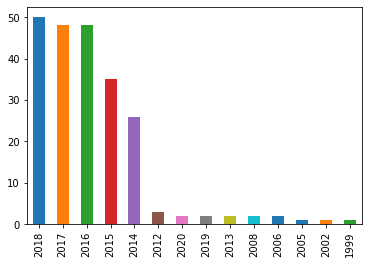

In [9]:
# Distribution by year
count_days['year'] = count_days.date.dt.year
count_days['month'] = count_days.date.dt.month
count_days['weekday'] = count_days.date.dt.weekday_name
count_days['yearmonth'] = count_days.date.map(lambda x: 100*x.year + x.month)

count_days["year"].value_counts().plot(kind='bar')

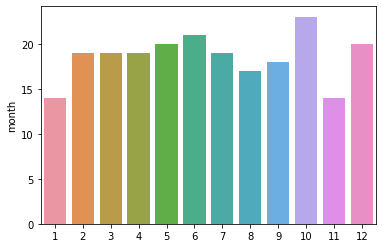

In [10]:
# Distribution by months
df_offers_by_month = pd.DataFrame(count_days['month'].value_counts())
# print(df_offers_by_month)

ax = sns.barplot(x=df_offers_by_month.index, y=df_offers_by_month.month, data=df_offers_by_month)

In [11]:
count_days["weekday"].describe()
# PROBLEME ?

count        223
unique         2
top       Friday
freq         222
Name: weekday, dtype: object

In [12]:
df['nb_requirements'].describe()

count    675.000000
mean       1.924444
std        1.080682
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        9.000000
Name: nb_requirements, dtype: float64

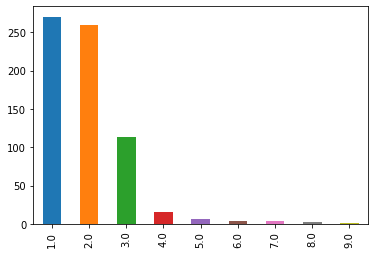

In [13]:
df['nb_requirements'].value_counts().plot(kind='bar')

In [14]:
df['nb_selection_steps'].describe()

count    675.000000
mean       1.263704
std        0.771392
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: nb_selection_steps, dtype: float64

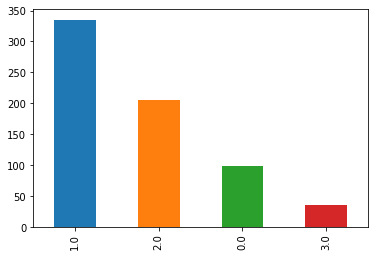

In [15]:
df['nb_selection_steps'].value_counts().plot(kind='bar')

In [16]:
df['nb_lines'].describe()

count     675
unique     63
top        83
freq       31
Name: nb_lines, dtype: int64

In [17]:
df['nb_lines'].value_counts().head(10)

83    31
85    29
80    29
76    28
82    26
81    26
78    26
77    25
88    25
84    24
Name: nb_lines, dtype: int64

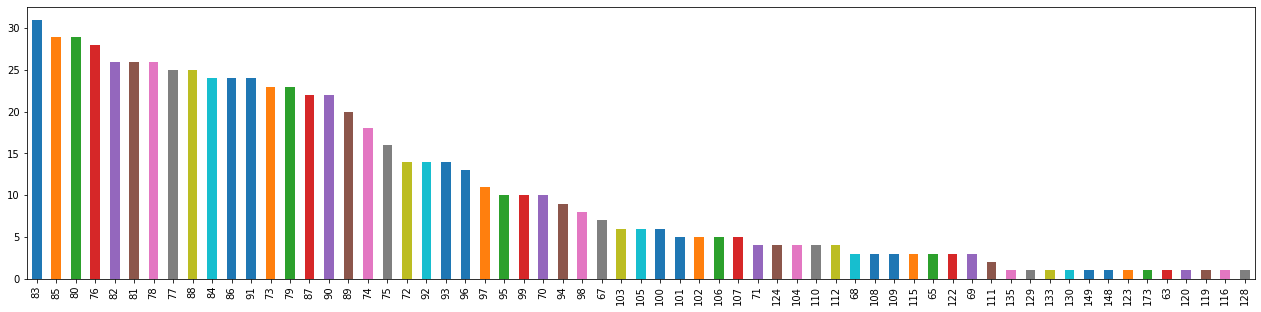

In [18]:
df['nb_lines'].value_counts().plot(kind='bar', figsize=(22,5))

In [19]:
df['validity_duration'].describe()

count     625
unique     38
top        13
freq      494
Name: validity_duration, dtype: int64

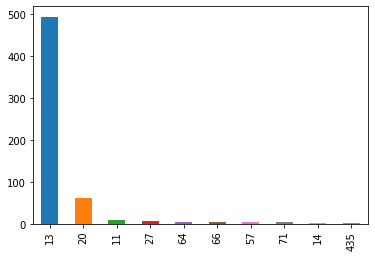

In [59]:
# Visualize To Pten validity_durations
df['validity_duration'].value_counts().head(10).plot(kind='bar')

In [21]:
df['validity_duration'].value_counts().head(10)

13     494
20      61
11      10
27       6
64       5
66       4
57       4
71       4
14       3
435      2
Name: validity_duration, dtype: int64

### 1.c Exploratory Analysis first conclusions
#### Reading entry file efficiency
- Over the 683 files we managed to read properly 675 files. the dataframe is then representative of the entry files to 98%.

#### Offered employment
- Before 2014, very few employment opportunities were offered to the citizen. As we approch 2021, we can see that the number of bulletins is increasing. There is a strong issue in managing the turnover since 2014. The niumber of job opportunities offred is almost doubled between 2014 and 2015, and then the number of published bulletins remain in high numbers. 
- This makes our job even more challenging !

#### Job posting all over the year
- It seams that the job posting is stable all over the year as the month number of bulletin ditribution by months is rather flat.

#### Number of requirements
- Largely, most of the bulletins display less that 4 requirements.
- However thet are few bulletins that include more requirements even up to 9 !
- Including lots of requirements help reduce the candidate number, but also increases chances of unconscious bias. This parameter is to be looked up.

#### Number of selection steps
- There are up to 3 steps for the selection (essay, written test and interview. 
- This procedure help the collectivity ensure they are hiring the appropriate candidate.
- 80%  of the job opportunities include 1 or 2 steps which are interview and written test. 
- 15% of them do not require a complex selection process.
- The remaning 5% of bulletins take into account a complex selection performed in 3 steps.
- Having a complex selection process may dissuade potentialcandidates, like disabled ones or women because of its duration and the availability required for attendig each appointment.

#### Validity duration
- Most (about 65%) of the job opportunities are to be applied within 13 days equivalent to 2 weeks since publishing of the bulletin.
- The next validity duration is 20 days equivalent to 3 weeks. 
- Up to 10 bulletin offer a validity duration of 10 days, which is rather short. This is the shortest validity duration.
- Validity duration is an important parameter. offering little time to apply reduces the number of candidates . It ca contribute to a disabled bias.







### 1.d Study of the legitimity of having so many requirements and selection steps

In this section we will add a section inside the dataframe to identify if a bulletin deals with a responsibilitae scale : 
- Director = 5, 
- Manager, Principal, Chief, Captain  = 4, 
- Engineer, Specialist, Representative, Advocate, Inspector, Officer = 3
- Supervisor = 2
- Other = 0

In [102]:
def RespLevel(position):
    results = 0
    if "DIRECTOR" in position.upper():
        return(5)
    
    elif "MANAGER" in position.upper():
        return(4)
    elif "PRINCIPAL" in position.upper():
        return(4)
    elif "CHIEF" in position.upper():
        return(4)
    elif "CAPTAIN" in position.upper():
        return(4)
    
    elif "ENGINEER" in position.upper():
        return(3)
    elif "SPECIALIST" in position.upper():
        return(3)
    elif "ADVOCATE" in position.upper():
        return(3)
    elif "REPRESENTATIVE" in position.upper():
        return(3)
    elif "INSPECTOR" in position.upper():
        return(3)
    elif "OFFICER" in position.upper():
        return(3)
    
    elif "SUPERVISOR" in position.upper():
        return(2)
    elif "LIEUTENANT" in position.upper():
        return(2)
    elif "SUPERINTENDENT" in position.upper():
        return(2)    
    
    else:
        return(0)
        
def open2all(raw_text):
    if "exam open to current" in raw_text.lower():
        return((0))
    elif "exam open to all" in raw_text.lower():
        return(1)
    else:
        #nothing is mentionned on whether external candidates can apply
        return(np.nan)
    
def mention_Exam_Open(raw_text):
    if "exam open" in raw_text.lower():
        return((1))
    else:
        return(0)
    
def tooMasculine(raw_text):
    if "masculine" in raw_text.lower():
        return((1))
    else:
        return(0)

def tooFeminine(raw_text):
    if "feminine" in raw_text.lower():
        return((1))
    else:
        return(0)

In [103]:
df_resp = df
df_resp['Resp_level'] = df_resp['Position'].apply(lambda x : RespLevel(x))
df_resp['Open_To_All'] = df_resp['raw_job_text'].apply(lambda x : open2all(x))
df_resp['Open_To_Mention'] = df_resp['raw_job_text'].apply(lambda x : mention_Exam_Open(x))



In [91]:
df_resp.head()


,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,nb_selection_steps,raw_job_text,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE,GENDER_WORDS,Resp_level,Open_To_Mention,Open_To_All
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,1.0,311 DIRECTOR Class Code: 9206 Open Date:...,One,FULL_TIME,NaN,NaN,neutral,5,0,0
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,2.0,ACCOUNTANT Class Code: 1513 Open Date: ...,NaN,NaN,four,College or University,strongly masculine-coded,0,1,1
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,1.0,ACCOUNTING CLERK Class Code: 1223 Open ...,Two,FULL_TIME,NaN,NaN,neutral,0,1,1
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,2.0,ACCOUNTING RECORDS SUPERVISOR Class Code: ...,Two,FULL_TIME,NaN,NaN,neutral,2,1,-1
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,3.0,ADMINISTRATIVE ANALYST Class Code: 1590...,One,FULL_TIME,four,College or University,strongly masculine-coded,0,1,-1


In [93]:
df_resp['Resp_level'].value_counts().head(10)

0    313
3    128
2    110
4     99
5     25
Name: Resp_level, dtype: int64

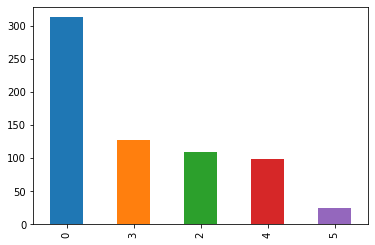

In [94]:
df_resp['Resp_level'].value_counts().head(10).plot(kind='bar')


#### Responsibility Level
- Most (about 49%) of the job opportunities are very low responsibility levels
- About 15% of the job positions may concern inspectors, supervisors, lieutenants
- About 35% of the job positions present a medium or high responibility level. 
- It would be a pity if the biases took places for those 35%

In [96]:
df_resp['Open_To_All'].value_counts()

 1    335
-1    305
 0     35
Name: Open_To_All, dtype: int64

#### About 35 Job bulletins (about 5%) do not specify whether the job is opent to external cadidates.

#### About 305 Job bulletins (about 45%) are only open to current city employees
This is Huge and this may reduce chances to view new candidates



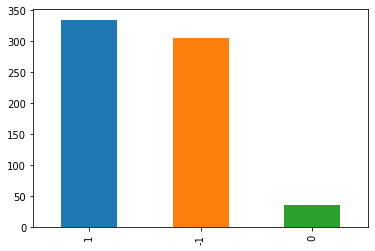

In [95]:
df_resp['Open_To_All'].value_counts().head().plot(kind='bar')

## 2. Gender bias analysis

Let's assign a "tendency" to each job posting based on the following paper :
https://www.hw.ac.uk/services/docs/gendered-wording-in-job-ads.pdf

In [99]:
df['GENDER_WORDS'] = df['duties'].apply(lambda x : assess.assess(x)['result'])
df_resp['GENDER_WORDS'] = df['duties'].apply(lambda x : assess.assess(x)['result'])
#df['GENDER_WORDS'] = df['duties'].apply(lambda x : genderdecoder.assess(x)['result'])

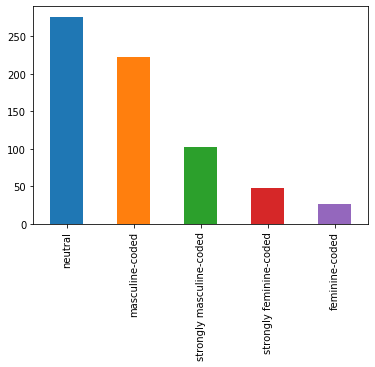

In [23]:
df_resp["GENDER_WORDS"].value_counts().plot(kind='bar')

In [100]:
df_resp["GENDER_WORDS"].value_counts()

neutral                     276
masculine-coded             222
strongly masculine-coded    102
strongly feminine-coded      48
feminine-coded               27
Name: GENDER_WORDS, dtype: int64

### There is an insight here !
41% of the bulletins are masculine coded including 
* 33% are masculine coded
* 8% are stringly masculine coded

## Whant are the bulletin that require immediate action to reduce unconscious biases ?
For this, we will look for bulletins with high masculine or high feminine coded language and check their responsibility level as well as the complexity of the selection, and the validity duration 


In [105]:
df_resp["TooMasculine"]= df_resp['GENDER_WORDS'].apply(lambda x : tooMasculine(x))
df_resp["TooFeminine"]= df_resp['GENDER_WORDS'].apply(lambda x : tooFeminine(x))
#df_big_biases = df_resp[df_resp[]>]

### Named Entity Recognition

In [25]:
df_encoded = df[["raw_job_text", "validity_duration", "Essay", "Interview", "WTest", "nb_requirements", "nb_selection_steps", "EXPERIENCE_LENGTH", "FULL_TIME_PART_TIME", "EDUCATION_YEARS", "SCHOOL_TYPE", "GENDER_WORDS"]]

In [26]:
import spacy
from pprint import pprint
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [27]:
bull = nlp(bulletins[0])
pprint([(X.text, X.label_) for X in bull.ents])

[('311', 'CARDINAL'), ('9206', 'CARDINAL')]


#### Enrichir le df avec les NER

In [29]:
def get_NER(text):
    doc = nlp(text)
    labels = [x.label_ for x in doc.ents]
    return Counter(labels)

df_encoded = pd.DataFrame()
df_encoded['NER'] = df_encoded['raw_job_text'].apply(lambda x : get_NER(x))

KeyError: 'raw_job_text'

In [30]:
df_encoded['NER'].head()

KeyError: 'NER'

In [147]:
test = nlp(df_encoded['raw_job_text'][0])
items = [x.text for x in test.ents]
Counter(items).most_common(3)

[('City', 7), ('311', 5), ('1', 4)]

In [145]:
from spacy import displacy
displacy.render(nlp(str(df_encoded['raw_job_text'][0])), jupyter=True, style='ent')

### Word Embedding

In [148]:
# TODO

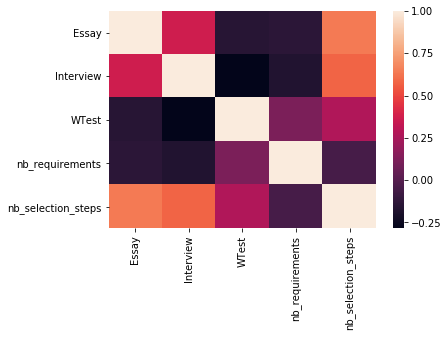

In [37]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Let's encode our dataframe categorical values to get more variables in the correlation matrix 

In [38]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Interview,WTest,nb_requirements,nb_selection_steps,raw_job_text,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE,GENDER_WORDS
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,1.0,0.0,3.0,1.0,311 DIRECTOR Class Code: 9206 Open Date:...,One,FULL_TIME,NaN,NaN,neutral
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,1.0,1.0,1.0,2.0,ACCOUNTANT Class Code: 1513 Open Date: ...,NaN,NaN,four,College or University,strongly masculine-coded
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,0.0,1.0,1.0,1.0,ACCOUNTING CLERK Class Code: 1223 Open ...,Two,FULL_TIME,NaN,NaN,neutral
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,1.0,1.0,1.0,2.0,ACCOUNTING RECORDS SUPERVISOR Class Code: ...,Two,FULL_TIME,NaN,NaN,neutral
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,1.0,1.0,3.0,3.0,ADMINISTRATIVE ANALYST Class Code: 1590...,One,FULL_TIME,four,College or University,strongly masculine-coded


In [39]:
df_encoded.head()

""


In [40]:
def isNaN(num):
    return num != num

def get_nb(val):
    if not isNaN(val):
        if val.lower() == 'one':
            return 1
        if val.lower() == 'two':
            return 2
        if val.lower() == 'three':
            return 3
        if val.lower() == 'four':
            return 4
        if val.lower() == 'five':
            return 5
        if val.lower() == 'six':
            return 6
        if val.lower() == 'seven':
            return 7
        if val.lower() == 'eight':
            return 8
        if val.lower() == 'nine':
            return 9
        if val.lower() == 'ten':
            return 10
        else:
            print(val)
            return np.nan
    
df_encoded['exp_years'] = df_encoded['EXPERIENCE_LENGTH'].apply(lambda x : get_nb(x))

KeyError: 'EXPERIENCE_LENGTH'

In [41]:
def code_ft_pt(val):
    if not isNaN(val):
        if val == "PART_TIME":
            return 1
        if val == "FULL_TIME":
            return 2
        else:
            return np.nan
        
df_encoded['full_time_part_time_code'] = df_encoded['FULL_TIME_PART_TIME'].apply(lambda x : code_ft_pt(x))

KeyError: 'FULL_TIME_PART_TIME'

In [50]:
def code_gender_bias(val):
    if not isNaN(val):
        if val == "neutral":
            return 0
        if val == 'masculine-coded':
            return 1
        if val == 'strongly masculine-coded':
            return 2
        if val == 'feminine-coded':
            return 3
        if val == 'strongly feminine-coded':
            return 4
        else:
            return np.nan
        
def code_school(val):
    if not isNaN(val):
        if val == "College or University":
            return 1 
        else: 
            return 0 
    
df_encoded['gender_bias_code'] = df_encoded['GENDER_WORDS'].apply(lambda x : code_gender_bias(x))
df_encoded['high_education'] = df_encoded['SCHOOL_TYPE'].apply(lambda x : code_school(x) )

C:\Users\Virginie\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Virginie\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
print(df_encoded['FULL_TIME_PART_TIME'].describe())
print(df_encoded['FULL_TIME_PART_TIME'].unique())
print(df_encoded['FULL_TIME_PART_TIME'].value_counts()) # ne compte pas les nan
print(df_encoded['FULL_TIME_PART_TIME'].isnull().sum()) # décompte des nan

count           576
unique            1
top       FULL_TIME
freq            576
Name: FULL_TIME_PART_TIME, dtype: object
['FULL_TIME' nan]
FULL_TIME    576
Name: FULL_TIME_PART_TIME, dtype: int64
99


FULL_TIME_PART_TIME contient des full time à 90%, le reste étant des NaN, supprimons cette colonne ainsi que les data categorical initiales

In [68]:
df_encoded.drop(columns=["full_time_part_time_code", "EXPERIENCE_LENGTH","FULL_TIME_PART_TIME", "EDUCATION_YEARS", "SCHOOL_TYPE", "GENDER_WORDS"], inplace=True)
df_encoded.head()

KeyError: "['EXPERIENCE_LENGTH' 'FULL_TIME_PART_TIME' 'EDUCATION_YEARS' 'SCHOOL_TYPE'\n 'GENDER_WORDS'] not found in axis"

In [70]:
print(df_encoded['high_education'].describe())
print(df_encoded['high_education'].unique())
print(df_encoded['high_education'].value_counts()) # ne compte pas les nan
print(df_encoded['high_education'].isnull().sum()) # décompte des nan

count    122.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: high_education, dtype: float64
[nan  1.]
1.0    122
Name: high_education, dtype: int64
553


C:\Users\Virginie\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


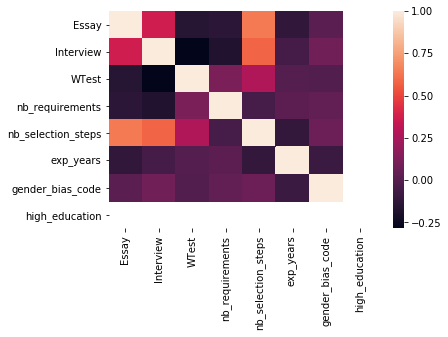

In [69]:
corr = df_encoded.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)